# Titanic competition via random forests

In this notebook, we will predict passenger survival using random forests.

We start off by loading some of the necessary libraries and the cleaned data generated in `titanic_data_cleaning.ipynb`.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [2]:
titanic = pd.read_csv( 'train_cleaned.csv' )
test = pd.read_csv( 'test_cleaned.csv' )

# Remove the 'PassengerId' from the data and keep the 'Survived' column as target vector Y.
submission=test[['PassengerId']]
test=test.drop('PassengerId', axis=1)

X=titanic.drop('Survived', axis=1)
X=X.drop('PassengerId', axis=1)
Y=titanic[['Survived']]
data=X.to_numpy()
target=Y.to_numpy().reshape(-1,)

y_true=Y.values.T[0] # ground truth vector

print(
"Training data shape:\t" + str(data.shape)
)


Training data shape:	(891, 27)


Next, we define the random forest classifier.

In [3]:
clf = RandomForestClassifier(n_estimators=500, criterion='gini', oob_score=True, n_jobs=-1, random_state=42)

## Choosing classifier parameters

We will focus on the parameters `min_samples_split` and `max_features` (see the documentation for more info).

By default, `max_features`  is set to the square root of the number of features which is $\sqrt{27}\approx 5$. However, for the random forset to work well wich such a low number of features, we would need all the features to be quite informative about the passenger's survival. It seems like many of our features alone (like ticket number length) might not be very informative. Thus, we set `max_features` to $8$ as a middle ground between having informative features and keeping the trees possibly uncorrelated.

Thus, we focus on the regularisation of the trees via controlling the `min_samples_split` parameter.

In [4]:
param_grid = { 
    "min_samples_split" : range(2,100,5),
    "max_features": [8]
}

In [5]:
search = GridSearchCV(
    clf, param_grid, n_jobs=-1, return_train_score=True, cv=StratifiedKFold(
        n_splits=10, shuffle=True, random_state=1234
    )
)

search.fit(data, target)

print(
    "Best parameter (CV score=%0.3f):" % search.best_score_
)

print(search.best_params_)

Best parameter (CV score=0.832):
{'max_features': 8, 'min_samples_split': 12}


For each `max_features` value, find the best classifier results.

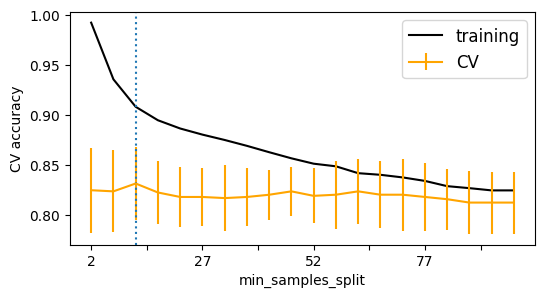

In [6]:
fig, ax1 = plt.subplots(nrows=1, figsize=(6, 6))
results = pd.DataFrame(search.cv_results_)
features_col = "param_min_samples_split"
best_clfs = results.groupby("param_min_samples_split").apply(
    lambda g: g.nlargest(1, "mean_test_score", keep='first')
)

best_clfs.plot(
    x=features_col, y="mean_train_score", legend=False, ax=ax1, c='black', label="training"
)

best_clfs.plot(
    x=features_col, y="mean_test_score", yerr="std_test_score", legend=False, ax=ax1, c='orange', label="CV"
)

ax1.axvline(
    np.where(
        best_clfs["param_min_samples_split"] == search.best_params_['min_samples_split']
    ),
    linestyle=":"
)

ax1.legend(prop=dict(size=12))

ax1.set_ylabel("CV accuracy")
ax1.set_xlabel("min_samples_split")
ax1.set_box_aspect(.5)

We can see that the CV accuracy does not change much when tuning the parameters, however the degree of overfitting changes significantly.

The grid search shows that the optimal value of the `min_samples_split` parameter is 7. However, because we would like to reduce overfitting, we will set `min_samples_split` to $30$.

## Predictions

We set `min_samples_split` and `max_features` parameters the optimal ones and fit the classifier.

In [7]:
opt_params={
    'min_samples_split': 30,
    'max_features': 8,
    'n_estimators': 500
}
clf.set_params(**opt_params)

clf.fit(data, target)
y_pred=clf.predict(data)
print("Training accuracy:\t"+str(accuracy_score(y_true, y_pred)))

scores = cross_val_score(
    clf, data, target, cv=StratifiedKFold(
        n_splits=5, shuffle=True
    ), scoring='accuracy'
)
print( "CV accuracy:\t" + str(scores.mean()) )
print( "CV std:\t" + str(scores.std()) )
print( "Out-of-bag score:\t" + str(clf.oob_score_) )

Training accuracy:	0.877665544332211
CV accuracy:	0.8327349193396524
CV std:	0.01919502511049196
Out-of-bag score:	0.8271604938271605


Finally, we create the submission file.

In [8]:
submission["Survived"]=clf.predict(test)
print(submission.head())
submission.to_csv('submission_forest.csv',index=False)

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
